In [369]:
import  pandas as pd
from matplotlib import pyplot as plt
import numpy as np

In [370]:
df = pd.read_csv("data.csv")

In [371]:
def categorize_air_quality(value):
    if value <= 50:
        return 'Good'
    elif 51 <= value <= 100:
        return 'Moderate'
    elif 101 <= value <= 150:
        return 'Unhealthy for Sensitive Groups'
    elif 151 <= value <= 200:
        return 'Unhealthy'
    else:
        return 'Hazardous'

In [372]:
df['Air Quality'] = df['Air Quality'].apply(categorize_air_quality)

In [373]:
df.isna().sum()


CO2            0
TVOC           0
PM10           0
PM2.5          0
CO             0
Air Quality    0
LDR            0
O3             0
Temp           0
Hum            0
ts             0
dtype: int64

In [374]:
df['Air Quality'].value_counts()

Air Quality
Moderate                          255994
Unhealthy                         174047
Unhealthy for Sensitive Groups     89972
Good                               43768
Hazardous                          26095
Name: count, dtype: int64

In [375]:
import numpy as np

# Select numerical columns
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Create a copy of the dataframe
df2 = df.copy()

# Initialize a variable to track the number of rows
previous_rows = df2.shape[0]

while True:
    # Calculate Q1, Q3, and IQR for numerical columns
    Q1 = df2[num_cols].quantile(0.25)
    Q3 = df2[num_cols].quantile(0.75)
    IQR = Q3 - Q1

    # Define outlier thresholds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify outliers
    outliers = ((df2[num_cols] < lower_bound) | (df2[num_cols] > upper_bound))

    # Remove rows with any outliers
    df2 = df2[~outliers.any(axis=1)]

    # Check the current number of rows
    current_rows = df2.shape[0]

    # If no rows were removed, stop the loop
    if current_rows == previous_rows:
        break
    
    # Update previous_rows for the next iteration
    previous_rows = current_rows

# df2 now contains the dataset with all outliers removed

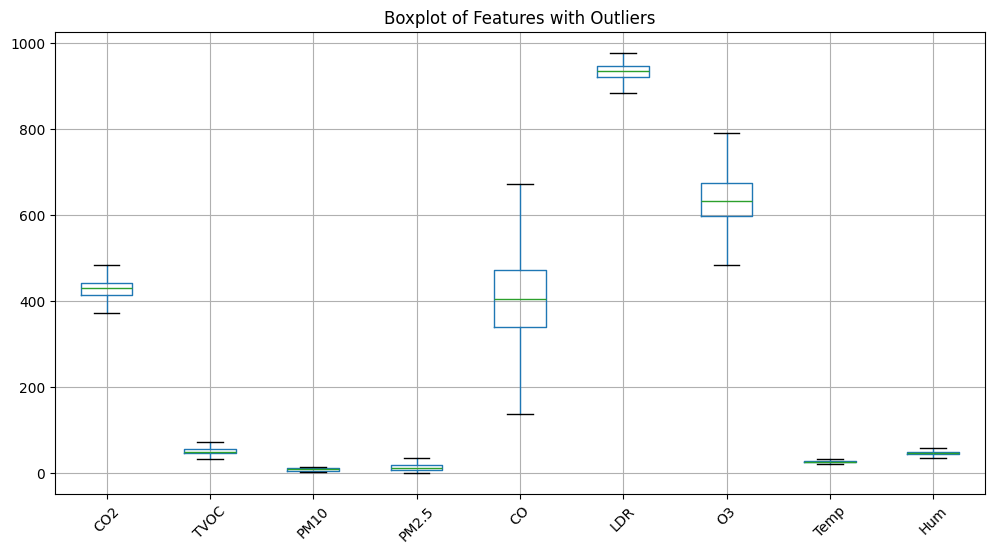

In [376]:
# Draw boxplots
plt.figure(figsize=(12, 6))
df2[num_cols].boxplot(rot=45)
plt.title("Boxplot of Features with Outliers")
plt.show()

In [377]:
df2.head()

,CO2,TVOC,PM10,PM2.5,CO,Air Quality,LDR,O3,Temp,Hum,ts
4375,400,45,5.45,29.7,284,Unhealthy for Sensitive Groups,978,510,26.2,39.5,2024-05-26T08:53:0
14912,406,48,9.31,7.6,171,Unhealthy for Sensitive Groups,975,512,25.0,50.7,2024-06-15T14:02:0
17262,400,42,11.58,3.8,383,Unhealthy,961,554,24.6,44.6,2024-06-19T22:49:2
17585,400,42,4.78,13.9,244,Unhealthy for Sensitive Groups,961,490,24.7,38.4,2024-06-20T04:12:1
21764,428,47,2.65,15.4,246,Unhealthy for Sensitive Groups,976,566,25.4,47.7,2024-06-29T16:33:3


In [378]:
df2.set_index("ts", inplace=True)  # Set timestamp as index

df2 = df2[df2.index< "2026-01-01"]

df2['ts'] = pd.to_datetime(df2.index, errors='coerce')
df2['month'] = df2['ts'].dt.month
df2.drop(axis=1, columns="ts", inplace=True)

In [379]:
df2.columns

Index(['CO2', 'TVOC', 'PM10', 'PM2.5', 'CO', 'Air Quality', 'LDR', 'O3',
       'Temp', 'Hum', 'month'],
      dtype='object')

In [380]:
X=df2.drop(axis=1,columns="Air Quality")
y=df2[["Air Quality"]]

In [381]:
X_train=X
y_train=y

In [382]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)


In [383]:
y_train.value_counts()

Air Quality                   
Moderate                          151364
Unhealthy                          87876
Unhealthy for Sensitive Groups     38064
Good                               13722
Hazardous                           7556
Name: count, dtype: int64

In [384]:
np.unique(y_train)

array(['Good', 'Hazardous', 'Moderate', 'Unhealthy',
       'Unhealthy for Sensitive Groups'], dtype=object)

In [385]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
y_train = np.ravel(y_train)  # or y_train = y_train.flatten()

# Encode labels
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)

# Ensure y_train is a 1D array
y_train_encoded = y_train_encoded.flatten()

# Compute class weights on the encoded labels
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_encoded), y=y_train_encoded)

print(class_weights)


[4.3518729  7.90317628 0.39452181 0.67955301 1.56884195]


In [386]:
class_weights = {i: float(w) for i, w in enumerate(class_weights)}


In [387]:
# class_weights = {i: w for i, w in enumerate(class_weights)}


In [388]:
class_weights

{0: 4.351872904824369,
 1: 7.903176283748015,
 2: 0.3945218149626067,
 3: 0.679553006509172,
 4: 1.5688419503993274}

In [389]:
X_train.shape, y_train_encoded.shape

((298582, 10), (298582,))

In [390]:
sequence_length = 60
target_length = 60

X_sequences = []
y_sequences = []

for i in range(len(X_train) - sequence_length - target_length + 1):
    X_sequences.append(X_train[i:i+sequence_length])
    y_sequences.append(y_train_encoded[i+sequence_length:i+sequence_length+target_length])

X_sequences = np.array(X_sequences)
y_sequences = np.array(y_sequences)

In [391]:
X_sequences.shape, y_sequences.shape

((298463, 60, 10), (298463, 60))

In [392]:
import tensorflow as tf 
# Convert to tensors
X_tensor = tf.convert_to_tensor(X_sequences, dtype=tf.float16)
y_tensor = tf.convert_to_tensor(y_sequences, dtype=tf.int8)

In [393]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Bidirectional, TimeDistributed, Dense
from tensorflow.keras.optimizers import Adam


num_classes = len(df2['Air Quality'].unique())  # Number of air quality categories
# sequence_length = 60  # Input timesteps
# target_length = 60    # Output timesteps
no_features = 10
model = Sequential([
    Input(shape=(sequence_length, no_features)),  # Input shape remains the same
    
    # CNN layers for feature extraction
    Conv1D(64, kernel_size=3, activation='relu', padding='same'),
    
    # Bidirectional LSTM layers
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(64, return_sequences=True)),
    
    # Final dense layers with TimeDistributed
    TimeDistributed(Dense(128, activation='relu')),
    TimeDistributed(Dense(num_classes, activation='softmax'))
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [394]:
type(class_weights)

dict

In [395]:
type(y_tensor)

tensorflow.python.framework.ops.EagerTensor

In [368]:
from tensorflow import keras
early_stopping = keras.callbacks.EarlyStopping(patience = 5, restore_best_weights = True, monitor = 'val_loss')

history = model.fit(X_tensor,
            y_tensor,
            validation_split=0.1,
            epochs=3,
            verbose=1,
            batch_size=256, 
            class_weight = class_weights,
            callbacks = [early_stopping]
            )


Epoch 1/3


I0000 00:00:1741806853.849041   36167 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-03-12 21:14:15.114534: W tensorflow/core/framework/op_kernel.cc:1829] INVALID_ARGUMENT: required broadcastable shapes
2025-03-12 21:14:15.114565: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: INVALID_ARGUMENT: required broadcastable shapes
	 [[{{function_node __inference_one_step_on_data_11939}}{{node compile_loss/sparse_categorical_crossentropy/mul}}]]


InvalidArgumentError: Graph execution error:

Detected at node compile_loss/sparse_categorical_crossentropy/mul defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/home/xxx/anaconda3/envs/deeplrr/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/xxx/anaconda3/envs/deeplrr/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/xxx/anaconda3/envs/deeplrr/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/xxx/anaconda3/envs/deeplrr/lib/python3.12/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/home/xxx/anaconda3/envs/deeplrr/lib/python3.12/asyncio/base_events.py", line 645, in run_forever

  File "/home/xxx/anaconda3/envs/deeplrr/lib/python3.12/asyncio/base_events.py", line 1999, in _run_once

  File "/home/xxx/anaconda3/envs/deeplrr/lib/python3.12/asyncio/events.py", line 88, in _run

  File "/home/xxx/anaconda3/envs/deeplrr/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/xxx/anaconda3/envs/deeplrr/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/xxx/anaconda3/envs/deeplrr/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/xxx/anaconda3/envs/deeplrr/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/home/xxx/anaconda3/envs/deeplrr/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/xxx/anaconda3/envs/deeplrr/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/home/xxx/anaconda3/envs/deeplrr/lib/python3.12/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/xxx/anaconda3/envs/deeplrr/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3044, in run_cell

  File "/home/xxx/anaconda3/envs/deeplrr/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3099, in _run_cell

  File "/home/xxx/anaconda3/envs/deeplrr/lib/python3.12/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/home/xxx/anaconda3/envs/deeplrr/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3303, in run_cell_async

  File "/home/xxx/anaconda3/envs/deeplrr/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3486, in run_ast_nodes

  File "/home/xxx/anaconda3/envs/deeplrr/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3546, in run_code

  File "/tmp/ipykernel_33791/1339888876.py", line 4, in <module>

  File "/home/xxx/anaconda3/envs/deeplrr/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/xxx/anaconda3/envs/deeplrr/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 371, in fit

  File "/home/xxx/anaconda3/envs/deeplrr/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 219, in function

  File "/home/xxx/anaconda3/envs/deeplrr/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 132, in multi_step_on_iterator

  File "/home/xxx/anaconda3/envs/deeplrr/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 113, in one_step_on_data

  File "/home/xxx/anaconda3/envs/deeplrr/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 60, in train_step

  File "/home/xxx/anaconda3/envs/deeplrr/lib/python3.12/site-packages/keras/src/trainers/trainer.py", line 383, in _compute_loss

  File "/home/xxx/anaconda3/envs/deeplrr/lib/python3.12/site-packages/keras/src/trainers/trainer.py", line 351, in compute_loss

  File "/home/xxx/anaconda3/envs/deeplrr/lib/python3.12/site-packages/keras/src/trainers/compile_utils.py", line 691, in __call__

  File "/home/xxx/anaconda3/envs/deeplrr/lib/python3.12/site-packages/keras/src/trainers/compile_utils.py", line 700, in call

  File "/home/xxx/anaconda3/envs/deeplrr/lib/python3.12/site-packages/keras/src/losses/loss.py", line 79, in __call__

  File "/home/xxx/anaconda3/envs/deeplrr/lib/python3.12/site-packages/keras/src/losses/loss.py", line 190, in reduce_weighted_values

required broadcastable shapes
	 [[{{node compile_loss/sparse_categorical_crossentropy/mul}}]] [Op:__inference_multi_step_on_iterator_12064]

In [404]:
# Create a sample_weight array with the same shape as y_tensor
sample_weight = np.ones_like(y_tensor, dtype=np.float32)

# Apply class weights per timestep
for cls, weight in class_weights.items():
    sample_weight[y_tensor == cls] = weight

history = model.fit(
    X_tensor,
    y_tensor,
    validation_split=0.1,
    epochs=5,
    verbose=1,
    batch_size=256,
    sample_weight=sample_weight,
    callbacks=[early_stopping]
)

Epoch 1/5
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 44s 42ms/step - accuracy: 0.8908 - loss: 0.2150 - val_accuracy: 0.8723 - val_loss: 0.5580
Epoch 2/5
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 44s 42ms/step - accuracy: 0.9123 - loss: 0.1611 - val_accuracy: 0.8858 - val_loss: 0.5321
Epoch 3/5
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 44s 42ms/step - accuracy: 0.9185 - loss: 0.1491 - val_accuracy: 0.8931 - val_loss: 0.5228
Epoch 4/5
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 44s 42ms/step - accuracy: 0.9246 - loss: 0.1373 - val_accuracy: 0.9248 - val_loss: 0.4270
Epoch 5/5
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 44s 42ms/step - accuracy: 0.9307 - loss: 0.1271 - val_accuracy: 0.9045 - val_loss: 0.5043


In [432]:
sample = 200000

X_tensor_reshaped = tf.expand_dims(X_tensor[sample], axis=0)  # Shape becomes (1, 60, 10)
predictions = model.predict(X_tensor_reshaped)
int_predictions = np.round(predictions).astype(int)

# Convert one-hot encoded predictions to class indices
class_indices = np.argmax(int_predictions, axis=-1)  # Shape: (1, 60)

# Flatten the array (remove batch dimension) if needed
class_indices = class_indices.flatten()  # Shape: (60,)
class_predictions = le.inverse_transform(class_indices)
class_predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


array(['Moderate', 'Moderate', 'Moderate', 'Moderate', 'Moderate',
       'Moderate', 'Moderate', 'Moderate', 'Moderate', 'Moderate',
       'Moderate', 'Moderate', 'Moderate', 'Moderate', 'Moderate',
       'Moderate', 'Moderate', 'Moderate', 'Moderate', 'Moderate',
       'Moderate', 'Moderate', 'Moderate', 'Moderate', 'Moderate',
       'Moderate', 'Moderate', 'Moderate', 'Moderate', 'Moderate',
       'Moderate', 'Moderate', 'Moderate', 'Moderate', 'Moderate',
       'Moderate', 'Moderate', 'Moderate', 'Moderate', 'Moderate',
       'Moderate', 'Moderate', 'Moderate', 'Moderate', 'Moderate',
       'Moderate', 'Moderate', 'Moderate', 'Moderate', 'Moderate',
       'Moderate', 'Moderate', 'Moderate', 'Moderate', 'Moderate',
       'Moderate', 'Moderate', 'Moderate', 'Moderate', 'Moderate'],
      dtype=object)

In [433]:
class_predictions = le.inverse_transform(y_tensor[sample+60])
class_predictions

array(['Moderate', 'Moderate', 'Moderate', 'Moderate', 'Moderate',
       'Moderate', 'Moderate', 'Moderate', 'Moderate', 'Moderate',
       'Moderate', 'Moderate', 'Moderate', 'Moderate', 'Moderate',
       'Moderate', 'Moderate', 'Moderate', 'Moderate', 'Moderate',
       'Moderate', 'Moderate', 'Moderate', 'Moderate', 'Moderate',
       'Moderate', 'Moderate', 'Moderate', 'Moderate', 'Moderate',
       'Moderate', 'Moderate', 'Moderate', 'Moderate', 'Moderate',
       'Moderate', 'Moderate', 'Moderate', 'Moderate', 'Moderate',
       'Moderate', 'Moderate', 'Moderate', 'Moderate', 'Moderate',
       'Moderate', 'Moderate', 'Moderate', 'Moderate', 'Moderate',
       'Moderate', 'Moderate', 'Moderate', 'Moderate', 'Moderate',
       'Moderate', 'Moderate', 'Moderate', 'Moderate', 'Moderate'],
      dtype=object)

In [423]:
y_tensor[sample]

<tf.Tensor: shape=(60,), dtype=int8, numpy=
array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], dtype=int8)>